# **Calories Burnt Prediction**

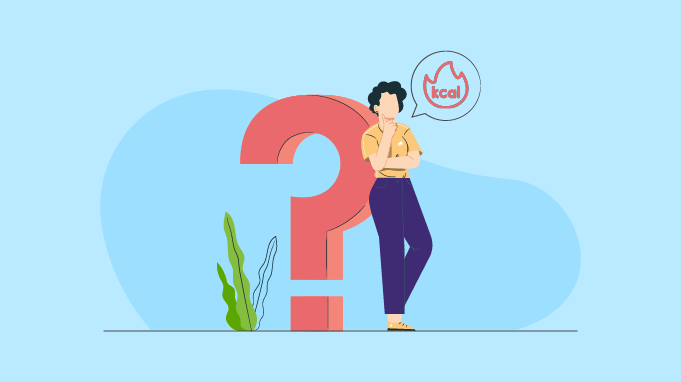

# Objective
Predict the number of calories burnt based on user demographics and exercise-related parameters using machine learning.

# Dataset Description
1. User_ID – Unique identifier for each user
2. Gender – 0 for Female, 1 for Male
3. Age – User's age
4. Height – User's height (cm)
5. Weight – User's weight (kg)
6. Duration – Duration of physical activity (minutes)
7. Heart_Rate – Heart rate during exercise (bpm)
8. Body_Temp – Body temperature after exercise (°C)
9. Calories – Calories burnt (target variable)

# Importing Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency

import joblib as jb
import pickle as pk1

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"E:\data science\Dataset\calories.csv")
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [3]:
df.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [6]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


> Observations from Data Summary
1. Age Range: 20 to 79 years (Good diversity in user age).
2. Height Range: 123 cm to 222 cm (Possible outliers at extreme values).
3. Weight Range: 36 kg to 132 kg (Relatively normal, but may need further checks).
4. Duration Range: 1 to 30 minutes (Short workout times).
5. Heart Rate: 67 to 128 bpm (Mostly normal, could be categorized into intensity levels).
6. Body Temperature: 37.1°C to 41.5°C (Physiologically possible, but higher values should be checked).
7. Calories Burnt: 1 to 314 kcal (Wide range, could be influenced by body weight and workout intensity).

In [7]:
# Checking null values

In [8]:
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

* There is no null values in the dataset

In [9]:
# Checking duplicate values

In [10]:
df.duplicated().sum()

np.int64(0)

* There is no duplicate values in the dataset.

# Handling Outliers

In [12]:
cols = ['Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories']

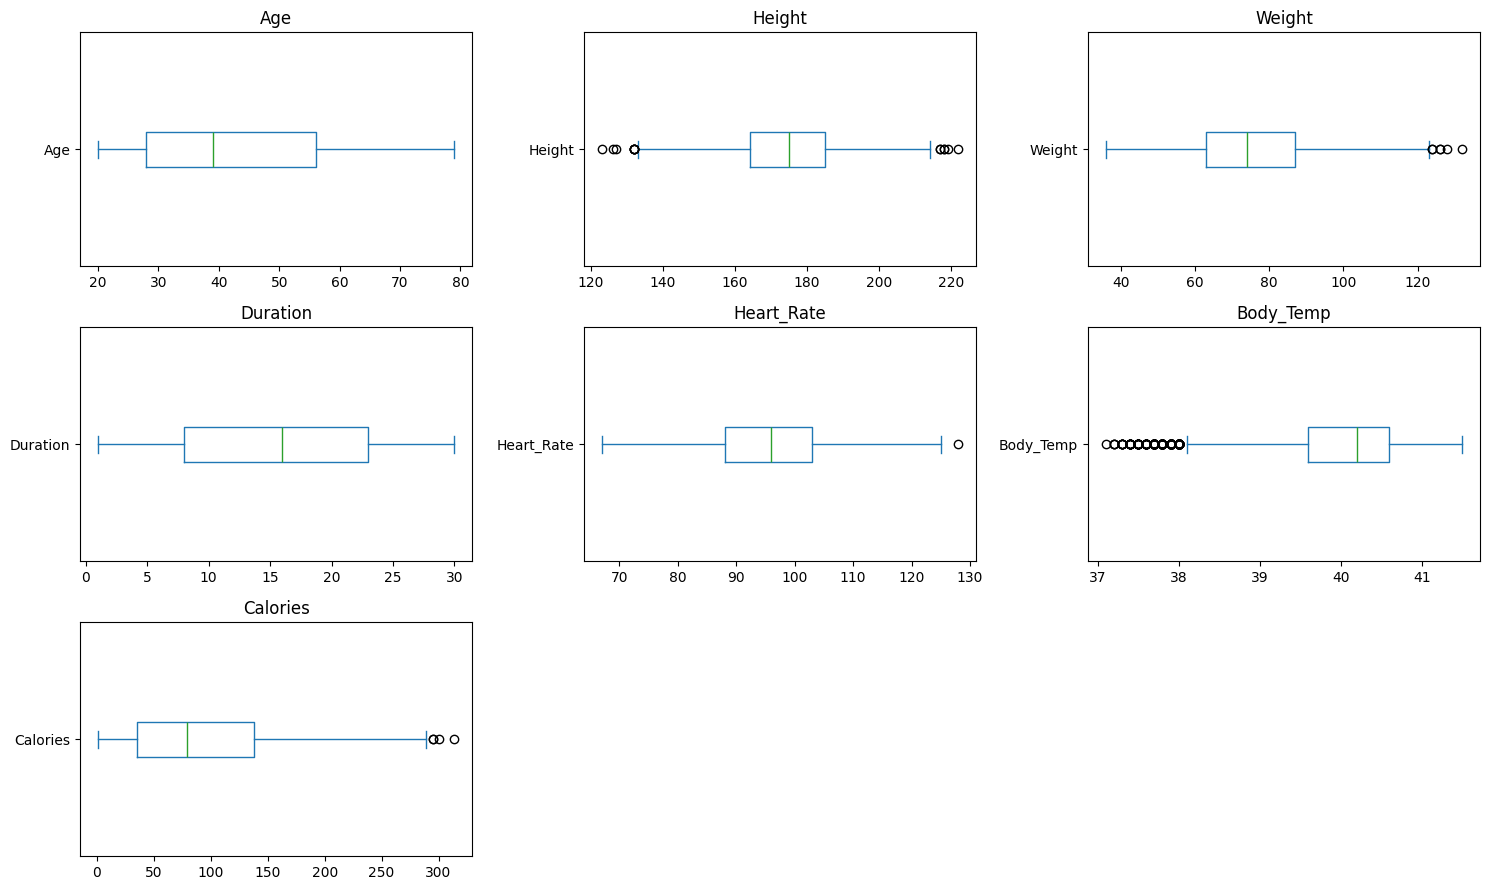

In [13]:
plt.figure(figsize=(15,9))
for z, i in enumerate(df[cols]):
    plt.subplot(3,3,z+1)
    df[i].plot.box(vert=False)
    plt.title(i)
plt.tight_layout()

* There is no such outliers in the columns

# Feature Engineering

> Create New Features
1. Body Mass Index (BMI) : BMI is a strong indicator of metabolism and calorie burn.
2. Workout Intensity Score : More intense workouts burn more calories.
3. Calories per Minute : Helps capture how efficiently a person burns calories.

In [15]:
df["BMI"] = df["Weight"] / ((df["Height"] / 100)**2)
df["Workout_Intensity"] = df["Heart_Rate"] / df["Duration"]
df["Calories_Per_Minute"] = df["Calories"] / df["Duration"]

In [16]:
df.head(2)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Calories_Per_Minute
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3.620690,7.965517
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,6.714286,4.714286


> Transform Existing Features
1. Categorize Duration into Short, Medium, Long Workouts
2. Age Grouping : Instead of raw Age, group into categories

In [18]:
df["Workout_Type"] = df["Duration"].map(lambda X : "Short" if X < 10 else "Medium" if X < 20 else "Long")

In [19]:
df["Age_Group"] = pd.cut(df["Age"],bins = [18, 30, 45, 60, 80], retbins=True,
                        labels=['Young', 'Adult', 'Middle-Aged', 'Senior'])[0]

In [20]:
df.head(2)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Calories_Per_Minute,Workout_Type,Age_Group
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3.620690,7.965517,Long,Senior
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,6.714286,4.714286,Medium,Young


# Distribution of Calories Burnt

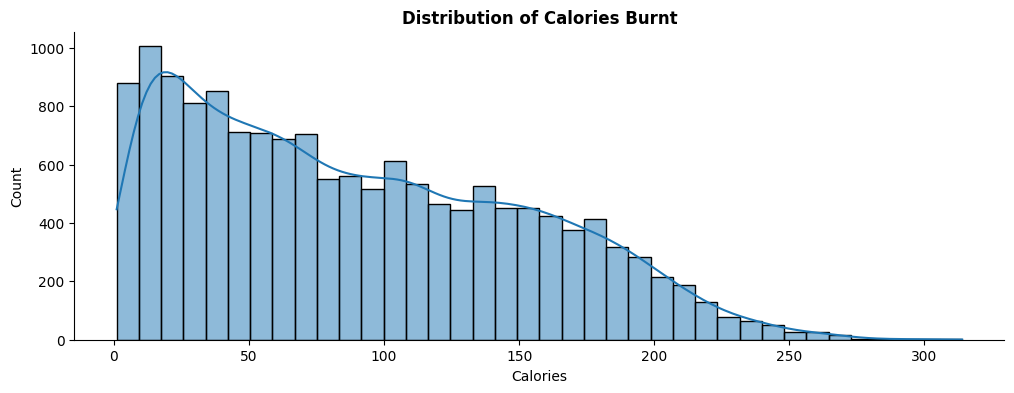

In [23]:
plt.figure(figsize=(12,4))
sns.histplot(df, x="Calories", kde=True)
plt.title("Distribution of Calories Burnt", fontsize=12, fontweight="bold")
sns.despine(top=True, right=True)
plt.show()

> Findings
1. Central Tendency & Spread
    * The most frequently occurring calorie values (modes) seem to be on the lower end, indicating that lower calorie burns are more common.
    * The data likely has a right-skewed distribution, meaning fewer instances of very high-calorie burns.
2. High & Low Burn Frequency
    * The lowest recorded calorie burn appears to be 7 calories with 161 occurrences, suggesting many light activity sessions.
    * The highest recorded burns (258-289 calories) are rare, each appearing only once in the dataset.
3. Potential Outliers
    * If most values cluster at lower calories, extreme values (above 200 calories) might be outliers or represent highly intense activity sessions.

# Calories Burnt by Gender

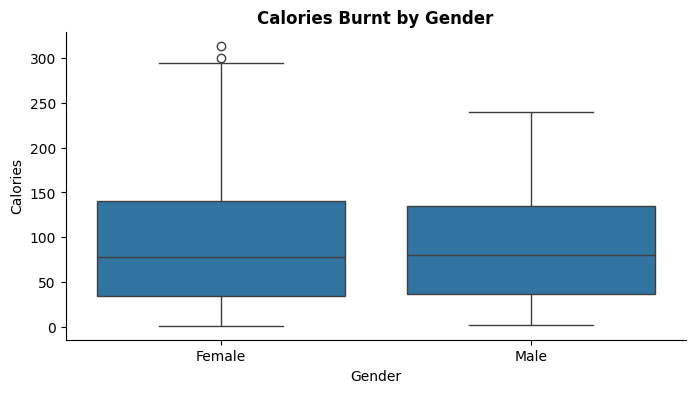

In [36]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Gender'], y=df['Calories'])
plt.title("Calories Burnt by Gender", fontsize=12, fontweight="bold")
plt.xticks([0, 1], ['Female', 'Male'])
sns.despine(top=True, right=True)
plt.show()

> Insights on Calories Burnt by Gender
1. Average Calories Burnt
* Males burn slightly more calories on average (90.95) than females (88.15).
* The difference is small (~2.8 calories), suggesting that overall energy expenditure is similar between genders.
2. Minimum & Maximum Values
* Minimum:
    * Female: 2 calories
    * Male: 1 calorie
* Both genders have very low recorded calorie burns, likely representing very short or low-intensity activities.
* Maximum:
    * Female: 240 calories
    * Male: 314 calories
* Males have a higher peak calorie burn, which might indicate higher intensity or longer-duration workouts among some male participants.
3. Potential Reasons for Differences
* The slightly higher average and max calories for males could be due to higher muscle mass, leading to increased calorie expenditure.
* Activity intensity and duration might differ between genders, contributing to this variation.

# Relationship Between Heart Rate & Calories

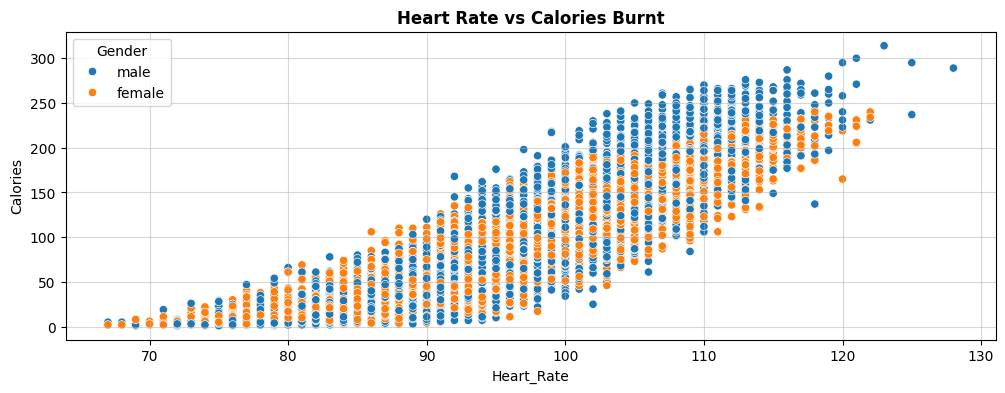

In [38]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Heart_Rate'], y=df['Calories'], hue=df['Gender'])
plt.title("Heart Rate vs Calories Burnt", fontsize=12, fontweight="bold")
plt.grid(alpha=0.5)
plt.show()

> Insights on Heart Rate vs. Calories Burnt
1. Positive Correlation
    * As heart rate increases, calories burnt also increase. This trend suggests that higher heart rates correspond to higher energy expenditure, which is expected since intense physical activity raises heart rate and burns more calories.
2. Gradual Increase in Calories
    * For lower heart rates (67-80 bpm), calorie burn remains relatively low (below 20 calories).
    * A noticeable increase starts around 85 bpm, with calorie burn crossing 30+ calories.
    * At 100 bpm and beyond, calorie burn accelerates significantly, reaching over 200 calories at the highest heart rates.
3. High Calorie Burns at Extreme Heart Rates
    * The highest calorie burns (237-314 calories) are observed at heart rates above 120 bpm, indicating intense cardiovascular activity.
    * An outlier exists at 123 bpm with 314 calories, which may represent an extreme workout session.

# Calories Burnt vs Workout Duration

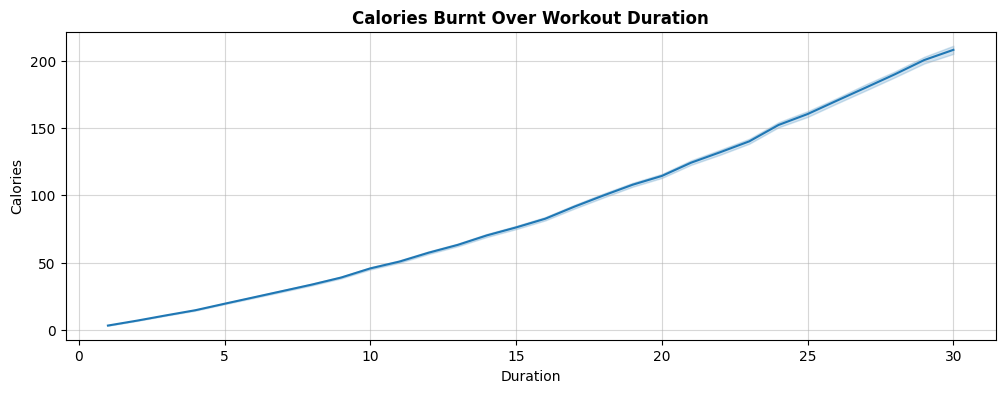

In [44]:
plt.figure(figsize=(12,4))
sns.lineplot(x=df['Duration'], y=df['Calories'])
plt.title("Calories Burnt Over Workout Duration", fontsize=12, fontweight="bold")
plt.grid(alpha=0.5)
plt.show()

> Insights on Calories Burnt vs. Workout Duration
1. Strong Positive Correlation
    * As workout duration increases, calories burnt also increase in a nearly linear fashion.
    * The relationship suggests that longer workouts result in significantly higher calorie burns.
2. Rate of Calorie Burn
    * For short workouts (1-5 min), calorie burn remains relatively low (3.3 - 19.5 calories).
    * 10-minute workouts already result in ~45 calories burnt.
    * 20-minute workouts burn ~114 calories, showing a steady rise.
    * 30-minute workouts burn over 200 calories, indicating a continuous increase in energy expenditure.
3. Efficiency of Longer Workouts
    * The increase in calorie burn appears consistent, meaning the workout intensity remains steady over time.
    * There are no sudden jumps, suggesting the calorie burn rate doesn’t accelerate significantly with longer durations but remains proportional.

# Calories Burnt Across Different Age Groups

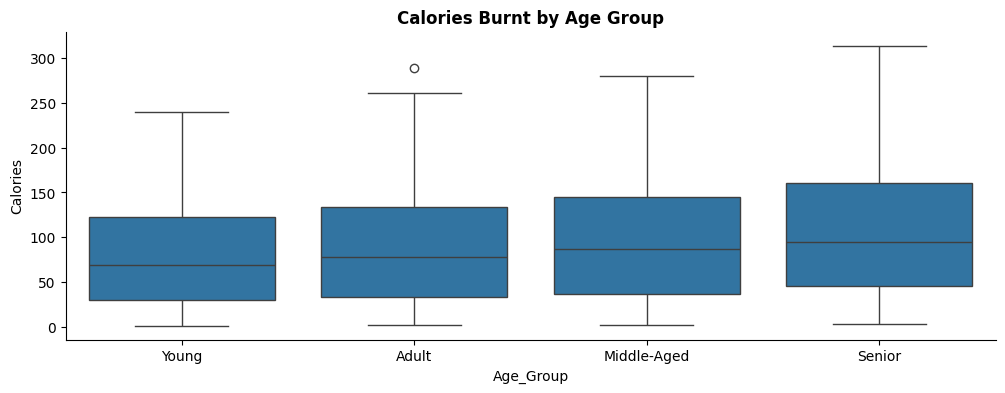

In [47]:
plt.figure(figsize=(12,4))
sns.boxplot(x='Age_Group', y='Calories', data=df)
plt.title("Calories Burnt by Age Group", fontsize=12, fontweight="bold")
sns.despine(top=True, right=True)
plt.show()

> Insights on Calories Burnt Across Different Age Groups
1. Increase in Calories Burnt with Age
    * Young (79.22) → Adult (86.92) → Middle-Aged (93.98) → Senior (105.38)
    * Older individuals tend to burn more calories on average, with seniors burning the most (105.38 calories).
2. Potential Explanations for the Trend
    * Workout Intensity & Duration: Older individuals may engage in longer or more intense workouts.
    * Metabolic Differences: While metabolism generally slows with age, the difference in calorie burn may reflect activity levels rather than just metabolic factors.
    * Health & Fitness Levels: Seniors who exercise regularly might be more committed to high-energy workouts.
3. Range of Calories Burnt
    * The minimum calorie burn is very low across all groups (1-3 calories), likely due to brief or low-intensity activities.
    * Maximum calorie burns are highest for Seniors (314 calories), indicating that some older individuals engage in very intense workouts.

# Distribution of Workout Durations

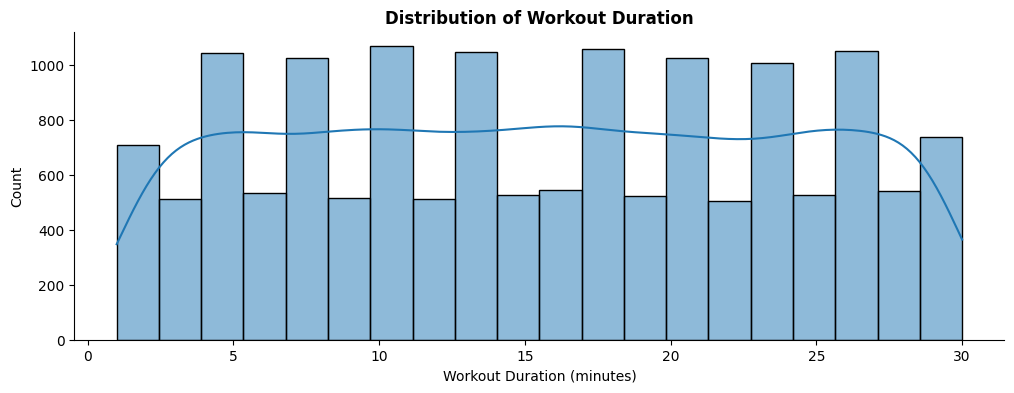

In [51]:
plt.figure(figsize=(12,4))
sns.histplot(df['Duration'], bins=20, kde=True)
plt.title("Distribution of Workout Duration", fontsize=12, fontweight="bold")
plt.xlabel("Workout Duration (minutes)")
plt.ylabel("Count")
sns.despine(top=True, right=True)
plt.show()

> Insights on Workout Duration Distribution
1. Most Common Workout Durations
    * The most frequent durations are 26 min (548 sessions), 16 min (546), and 17 min (543).
    * Durations ranging between 5 to 28 minutes have high frequencies, suggesting that most workouts fall in this range.
2. Shorter & Longer Workouts
    * Very short workouts (1-4 min) occur less frequently, indicating that users rarely engage in extremely brief sessions.
    * Longer workouts (30 min) are also relatively rare (255 sessions), suggesting fewer participants opt for extended workouts.
3. Balanced Spread with Slight Drop at Extremes
    * The data appears fairly evenly distributed within the 5-28 minute range.
    * However, workouts at 1, 2, and 30 minutes are significantly less common, possibly indicating that users prefer moderate workout durations over extremes.

# Calories Burnt vs BMI

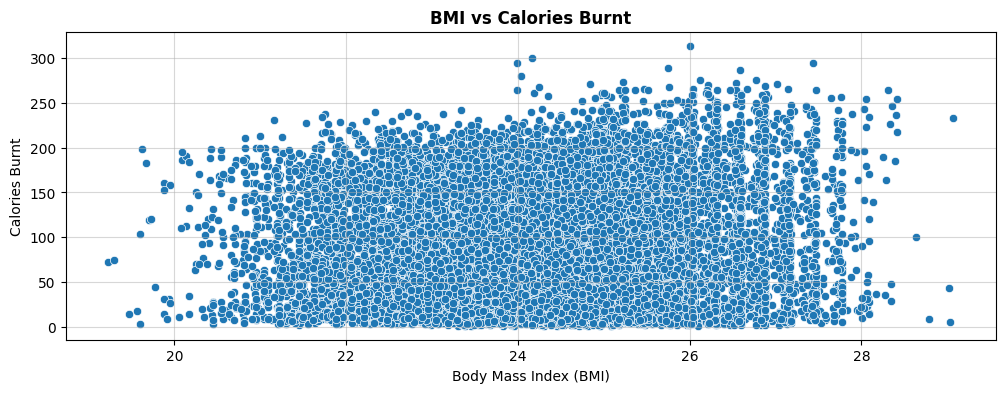

In [53]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['BMI'], y=df['Calories'])
plt.title("BMI vs Calories Burnt", fontsize=12, fontweight="bold")
plt.grid(alpha=0.5)
plt.xlabel("Body Mass Index (BMI)")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Calories Burnt vs. BMI
1. Higher BMI Often Correlates with Higher Calories Burnt
    * Individuals with higher BMI values (26–29 range) tend to burn more calories (~250-276 calories).
    * This is likely because heavier individuals expend more energy for the same workout due to increased body mass.
2. Lower BMI Individuals Burn Fewer Calories
    * At lower BMI values (19-22 range), calorie burns are significantly lower (2-5 calories).
    * This could be due to shorter or lower-intensity workouts, or lower energy requirements for movement.
3. Potential Non-Linear Trend
    * The relationship between BMI and calories burnt may not be perfectly linear—other factors like fitness level, muscle mass, and workout type also play a role.
    * Some individuals with mid-range BMI values (22-27) also show lower calorie burns, indicating possible variations in workout intensity.

# Workout Type vs Calories Burnt

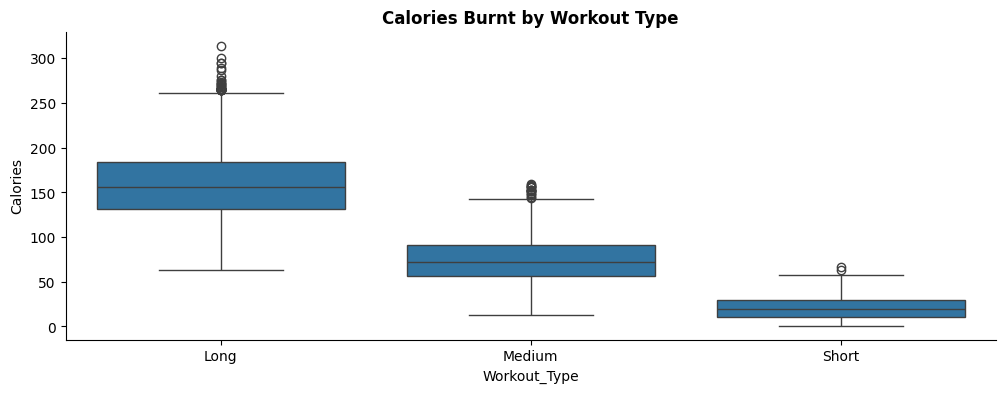

In [57]:
plt.figure(figsize=(12,4))
sns.boxplot(x='Workout_Type', y='Calories', data=df)
plt.title("Calories Burnt by Workout Type", fontsize=12, fontweight="bold")
sns.despine(top=True, right=True)
plt.show()

> Insights on Workout Type vs. Calories Burnt
1. Long Workouts Burn the Most Calories
* Mean calories burnt:
    * Long workouts → 158.98 calories
    * Medium workouts → 74.56 calories
    * Short workouts → 21.43 calories
* As expected, longer workouts lead to significantly higher calorie burns due to extended exercise duration.
2. Minimum and Maximum Calories Burnt
* Short workouts: Some individuals burn as little as 1 calorie, suggesting very brief or low-intensity sessions.
* Medium workouts: Range from 13 to 159 calories, indicating moderate activity levels.
* Long workouts: Range from 63 to 314 calories, showing greater variation in intensity.
3. Exponential Increase in Calories with Workout Length
* Short to medium workouts (~3.5x calorie increase): Jump from 21 to 74 calories.
* Medium to long workouts (~2x calorie increase): Jump from 74 to 158 calories.
* Suggests that calorie burn does not just scale linearly with time—longer workouts might also involve more intense exercises.

# Age vs Calories Burnt

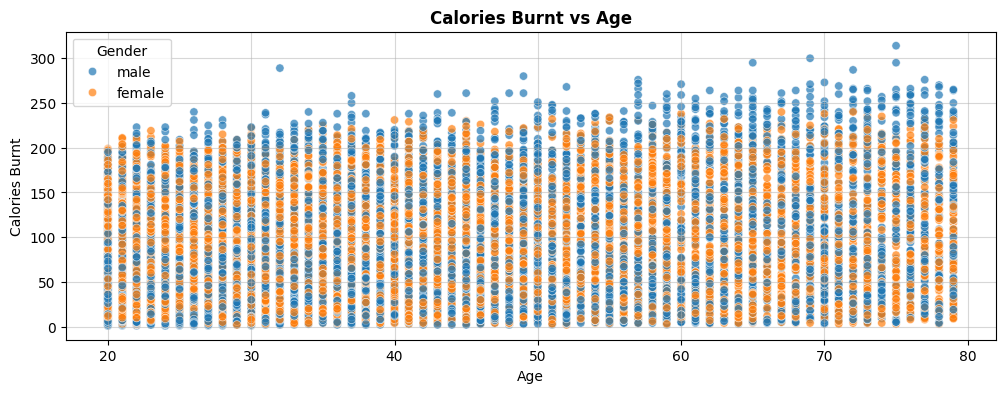

In [62]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Age'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Age", fontsize=12, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Age vs. Calories Burnt
1. Gradual Increase in Calories Burnt with Age
* Younger individuals (20-30 years) burn ~71-83 calories on average.
* Middle-aged individuals (30-50 years) burn ~77-99 calories, showing a gradual increase.
* Older adults (50+ years) see a further increase, peaking around 118 calories at age 75.
2. Higher Calories Burnt in Older Age Groups
* Calories burnt tend to be higher for individuals aged 60+, with many exceeding 100 calories.
* The highest average burn is seen around age 75 (118.96 calories).
3. Possible Explanations for This Trend
* Workout Type/Intensity: Older individuals may engage in longer or more structured workouts, contributing to higher burns.
* Weight Differences: Older individuals might have higher body weight, leading to increased calorie expenditure.
* Cardio-Focused Exercise: Seniors might focus more on steady-state cardio, which can result in consistent calorie burning over time.

# Height vs Calories Burnt

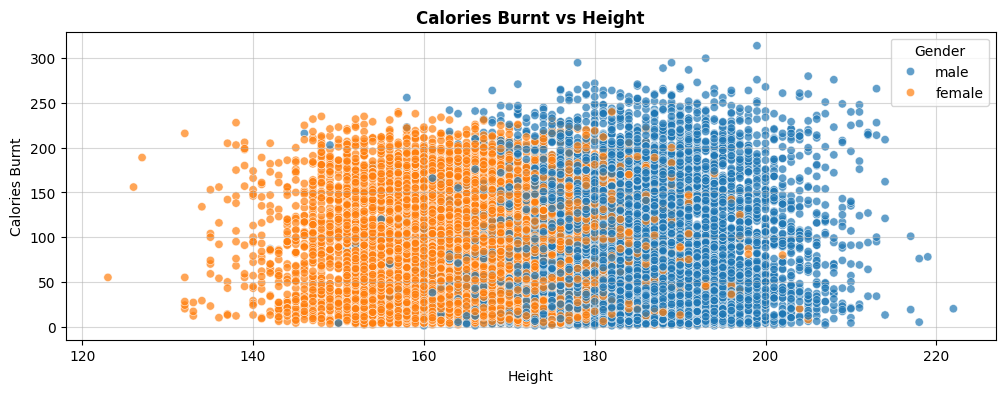

In [67]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Height'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Height", fontsize=12, fontweight="bold")
plt.xlabel("Height")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Height vs. Calories Burnt
1. No Clear Linear Relationship
* Some of the shortest individuals (127 cm, 126 cm) burn high calories (~189, 156).
* Taller individuals show mixed calorie burns, e.g.:
    * 213 cm → 156.17 calories (relatively high)
    * 218 cm → 40.5 calories (significantly lower)
2. Possible Factors Affecting Calories Burnt
* Workout Type & Intensity: Shorter individuals burning more calories may be doing high-intensity workouts.
* Metabolism Differences: Taller individuals often have a higher basal metabolic rate (BMR), but that doesn’t always translate to higher workout calories.
* Weight Influence: A taller person's weight might affect calorie burn—BMI vs. Calories Burnt could clarify this.
3. Extreme Cases to Investigate
* Short individuals (e.g., 133 cm, 123 cm) burning < 20 calories → Likely short or low-intensity workouts.
* Tall individuals burning low calories → Could indicate less intensity or shorter duration workouts.

# Weight vs Calories Burnt

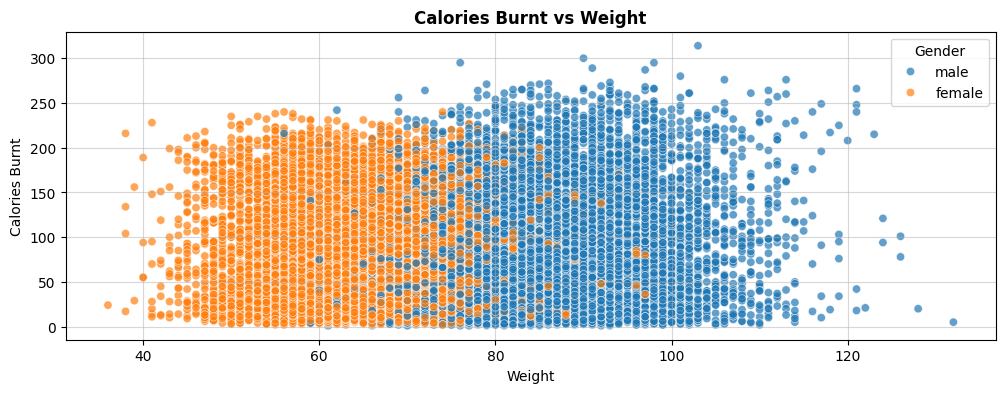

In [68]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Weight'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Weight", fontsize=12, fontweight="bold")
plt.xlabel("Weight")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Weight vs. Calories Burnt
1. Higher Weight Generally Leads to Higher Calorie Burn
* Heavier individuals (120-123 kg) burn ~208-215 calories on average.
* Lighter individuals (36-42 kg) burn significantly lower (~24-65 calories).
2. Outliers & Unexpected Trends
* A 122 kg person burning only 21 calories is an anomaly—this could indicate a very short workout or incorrect data.
* A 128 kg person burning 20 calories seems unexpectedly low for their weight.
3. Possible Factors Influencing Calories Burnt
* Workout Intensity & Type: Heavier individuals may engage in longer or more intense workouts, leading to higher calorie burn.
* Metabolic Differences: A higher body weight naturally increases calorie burn due to more energy expenditure.
* Duration of Exercise: If a heavier individual did a very short workout, it could explain low calorie burn cases.

# Body Temperature vs Calories Burnt

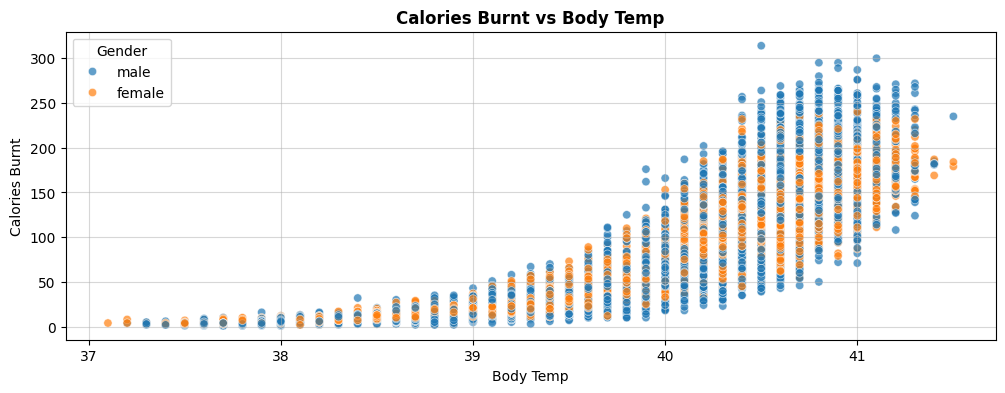

In [70]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Body_Temp'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Body Temp", fontsize=12, fontweight="bold")
plt.xlabel("Body Temp")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Body Temperature vs. Calories Burnt
1. Higher Body Temperature Leads to More Calories Burnt
* Individuals with a higher body temperature (~41.5°C) burn ~199 calories on average.
* Those with a lower temperature (~37.4°C) burn as low as ~3 calories.
* This suggests a strong positive correlation between body temperature and calories burnt.
2. Possible Explanations
* Increased Metabolic Activity: Higher body temperature is often a sign of higher metabolic rate, leading to more energy expenditure.
* Exercise Intensity: Strenuous workouts can increase body temperature, which aligns with the trend of higher calorie burn.
* Sweating & Thermoregulation: The body works harder to cool down, burning additional calories.
3. Outliers & Anomalies
* A sharp decline in calories burnt as temperature drops below 40°C suggests that those individuals may have done short or low-intensity workouts.
* It would be interesting to see if other factors (e.g., workout type, duration, age) influence this relationship.

# Workout Intensity vs Calories Burnt

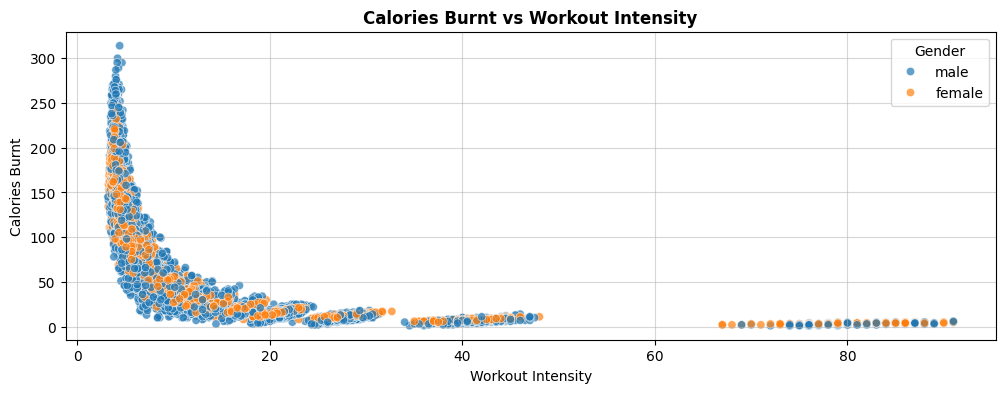

In [72]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Workout_Intensity'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Workout Intensity", fontsize=12, fontweight="bold")
plt.xlabel("Workout Intensity")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Workout Intensity vs. Calories Burnt
1. Higher Workout Intensity Leads to Higher Calories Burnt
* Individuals with low-intensity workouts (e.g., 4.39) burned up to 314 calories.
* Those with extreme intensity (e.g., 71) burned only ~2 calories, which seems like an outlier.
* Possible trend: Moderate-to-high intensity workouts (around 4-5) lead to the highest calorie burns.
2. Possible Explanations
* Sustained Effort Matters: High-calorie burns are achieved at moderate-to-high intensity rather than extreme intensity.
* Short Bursts at High Intensity: Individuals with very high intensity (~70+) might not sustain the workout long enough to burn significant calories.
* Variability in Measurement: It would be useful to check how "Workout Intensity" is defined (e.g., heart rate zones, METs, or self-reported effort).
3. Outliers & Anomalies
* Intensities above 30 showing very low calorie burns (~1-2 calories) could be due to data entry errors or very short workouts.
* Would be useful to cross-check with workout duration to understand how long these intense workouts lasted.

# Calories Per Minute vs Calories Burnt

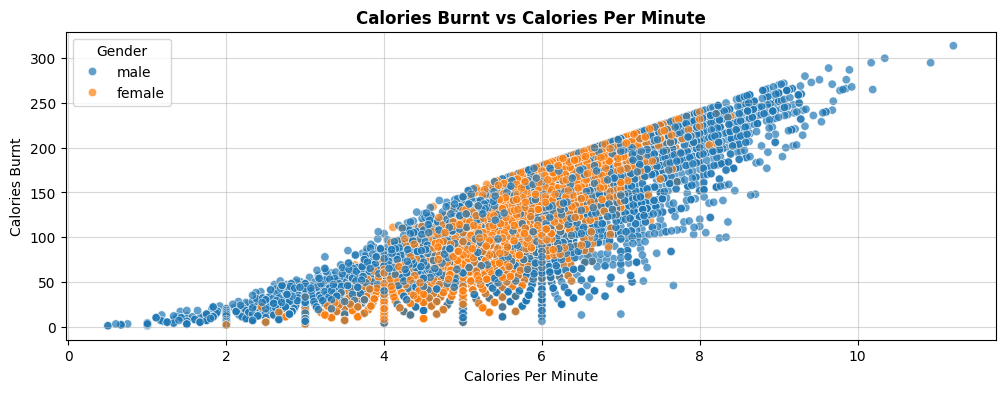

In [74]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=df['Calories_Per_Minute'], y=df['Calories'], alpha=0.7, hue=df['Gender'])
plt.grid(alpha=0.5)
plt.title("Calories Burnt vs Calories Per Minute", fontsize=12, fontweight="bold")
plt.xlabel("Calories Per Minute")
plt.ylabel("Calories Burnt")
plt.show()

> Insights on Calories Per Minute vs. Calories Burnt
1. Higher Calories Per Minute → More Total Calories Burnt
* The highest calorie burns (~314 kcal) correspond to 11+ calories per minute.
* Lower calorie burns (~1-3 kcal) correspond to very low burn rates (≤1 kcal/min).
* Trend: The more intense and sustained the workout, the greater the total calorie burn.
2. Efficiency of Workouts
* Individuals burning 10+ kcal/min are likely doing high-intensity or strength-based exercises.
* Those below 1 kcal/min might be engaging in light activity or very short workouts.
3. Possible Outliers & Variations
* A 0.5 kcal/min rate with only 1 calorie burnt suggests a very short workout duration.
* Would be useful to check workout duration to confirm if these are anomalies.

# Heatmap of Feature Correlations

In [76]:
df.drop("User_ID",axis=1, inplace=True)

In [77]:
data = df.copy()

In [78]:
data.head(2)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Calories_Per_Minute,Workout_Type,Age_Group
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3.620690,7.965517,Long,Senior
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,6.714286,4.714286,Medium,Young


In [80]:
le = LabelEncoder()

In [81]:
data["Gender"] = le.fit_transform(data["Gender"])
data["Workout_Type"] = le.fit_transform(data["Workout_Type"])
data["Age_Group"] = le.fit_transform(data["Age_Group"])

In [82]:
data.head(2)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Calories_Per_Minute,Workout_Type,Age_Group
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3.620690,7.965517,0,2
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,6.714286,4.714286,1,3


In [83]:
scalar = StandardScaler()

In [86]:
cols = ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'BMI', 'Workout_Intensity',
       'Calories_Per_Minute', 'Workout_Type', 'Age_Group']

In [92]:
data[['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'BMI', 'Workout_Intensity',
       'Calories_Per_Minute', 'Workout_Type', 'Age_Group']] = scalar.fit_transform(data[['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'BMI', 'Workout_Intensity',
       'Calories_Per_Minute', 'Workout_Type', 'Age_Group']])

In [93]:
data = data[['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'BMI', 'Workout_Intensity',
       'Calories_Per_Minute', 'Workout_Type', 'Age_Group', 'Calories']]

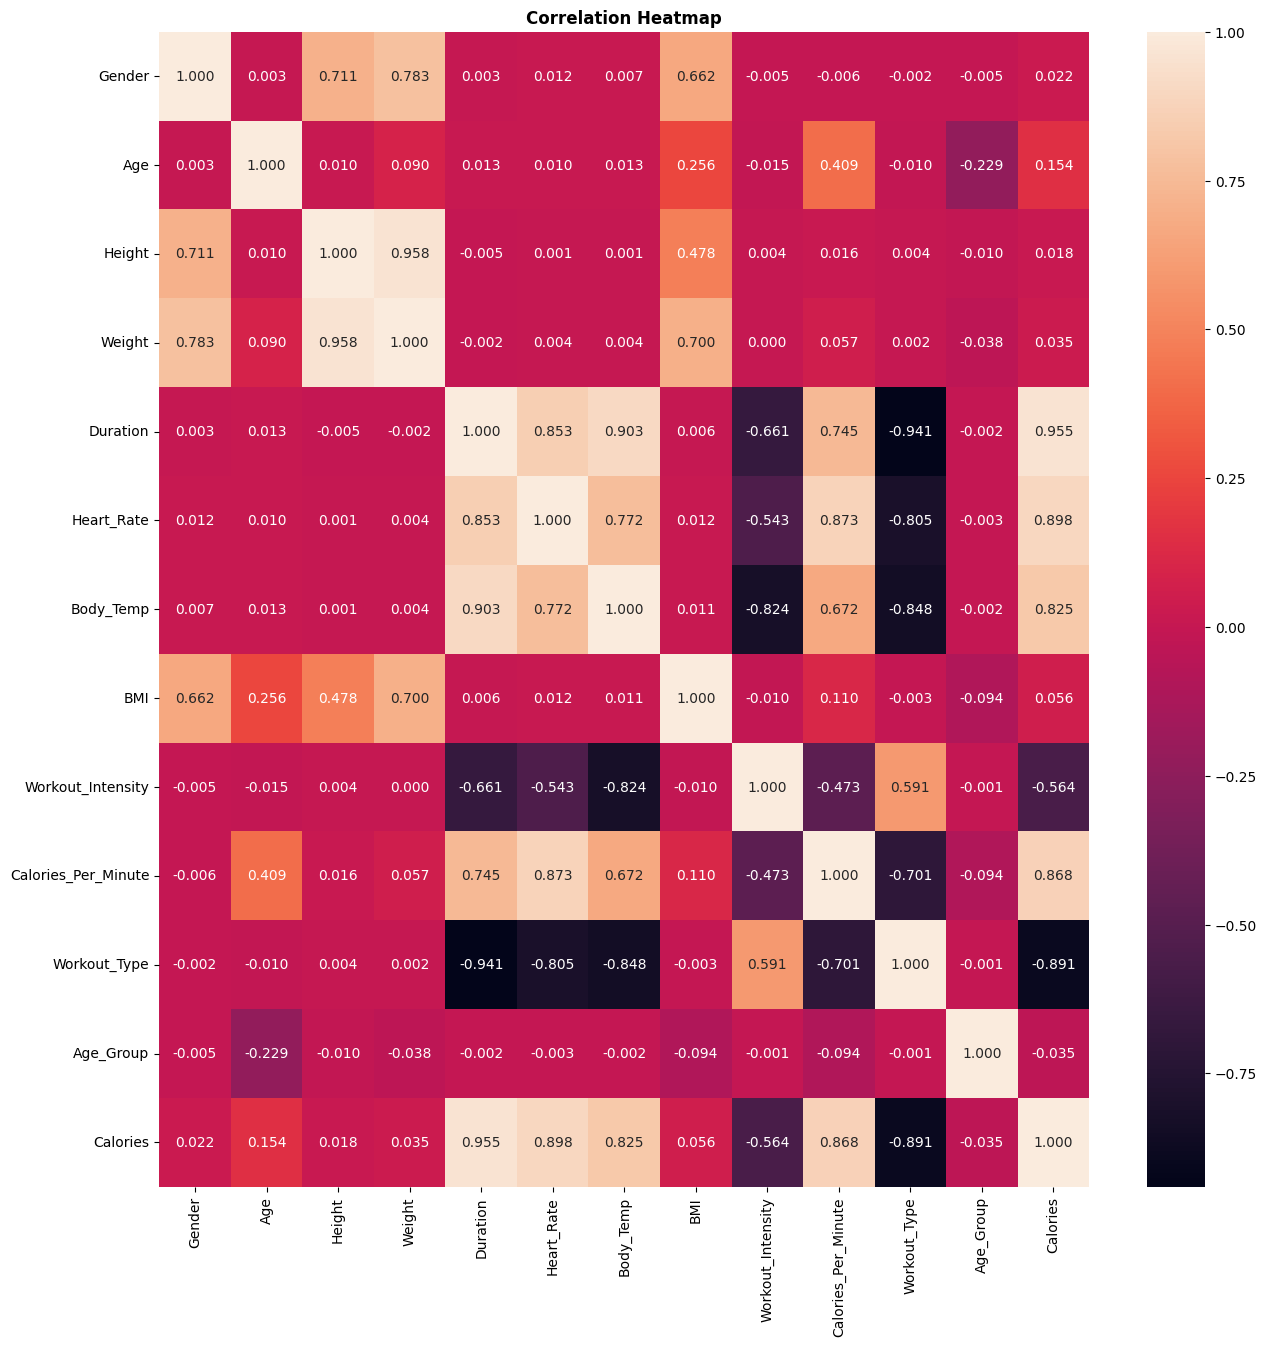

In [94]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, fmt=".3f")
plt.title("Correlation Heatmap", fontsize=12, fontweight="bold")
plt.show()

> Correlation Insights on Calories Burnt
1. Strongest Positive Correlations with Calories Burnt:
* Duration (0.955) → Longer workouts burn more calories.
* Heart Rate (0.898) → Higher heart rates lead to more calories burnt.
* Body Temperature (0.825) → Increased exertion raises body temp, leading to more calorie burn.
* Calories Per Minute (0.868) → The efficiency of the workout contributes significantly to total calories.
2. Strongest Negative Correlations:
* Workout Type (-0.891) → This suggests longer workouts (like endurance-based) may burn more calories, whereas shorter workouts burn fewer.
* Workout Intensity (-0.564) → Higher intensity does not always mean higher total calories, likely because shorter high-intensity workouts burn fewer total calories.
3. Moderate Positive Correlations:
* BMI (0.056), Weight (0.035), Age (0.154) → Slight impact, but not the most significant drivers.
4. Workout duration is the biggest factor in calories burnt.
5. High-intensity workouts burn more per minute, but longer workouts burn more overall.
6. Heart rate and body temperature are strong indicators of calorie burn.
7. Workout type matters—short workouts (e.g., HIIT) burn high per minute but not the most overall.

# Train Test Split Data

In [96]:
df["Gender"] = le.fit_transform(df["Gender"])
df["Workout_Type"] = le.fit_transform(df["Workout_Type"])
df["Age_Group"] = le.fit_transform(df["Age_Group"])

In [97]:
df.head(2)

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Workout_Intensity,Calories_Per_Minute,Workout_Type,Age_Group
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0,26.038781,3.620690,7.965517,0,2
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0,21.773842,6.714286,4.714286,1,3


In [98]:
X = df.drop("Calories", axis=1)
y = df["Calories"]

In [99]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [100]:
lr_pipeline = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", LinearRegression())
])
lr_pipeline.fit(X_tr, y_tr)

print("Training Score : ",lr_pipeline.score(X_tr, y_tr))
pred = lr_pipeline.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  0.9777831469565932
R2 Score :  0.97801246847173
MAE :  7.050241035090849
MSE :  88.73709234939015


# Decision Tree

In [101]:
dt_pipeline = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", DecisionTreeRegressor())
])
dt_pipeline.fit(X_tr, y_tr)

print("Training Score : ",dt_pipeline.score(X_tr, y_tr))
pred = dt_pipeline.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  1.0
R2 Score :  0.9997697271183229
MAE :  0.17533333333333334
MSE :  0.9293333333333333


# Random Forest

In [102]:
rf_pipeline = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", RandomForestRegressor())
])
rf_pipeline.fit(X_tr, y_tr)

print("Training Score : ",rf_pipeline.score(X_tr, y_tr))
pred = rf_pipeline.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  0.9999823683990261
R2 Score :  0.9999096237003203
MAE :  0.14781000000000014
MSE :  0.3647398999999999


# Adaboost

In [103]:
ada_pipeline = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", AdaBoostRegressor(estimator=DecisionTreeRegressor()))
])
ada_pipeline.fit(X_tr, y_tr)

print("Training Score : ",ada_pipeline.score(X_tr, y_tr))
pred = ada_pipeline.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  1.0
R2 Score :  0.9998621501292974
MAE :  0.111
MSE :  0.5563333333333333


# SVR

In [104]:
svr_pipeline = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", SVR(kernel="linear"))
])
svr_pipeline.fit(X_tr, y_tr)

print("Training Score : ",svr_pipeline.score(X_tr, y_tr))
pred = svr_pipeline.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  0.9758625774498949
R2 Score :  0.975529136458401
MAE :  6.932585496853465
MSE :  98.75930252417211


# Model Performance Comparison 
1. Best Overall Model: Random Forest Regressor
* R² Score: 0.9999 (very high accuracy)
* MAE: 0.148 (lowest absolute error)
* MSE: 0.365 (very low error)
* Training Score: 0.99998 (almost perfect)
* **Best balance between accuracy and generalization**
2. Runner-Up: Decision Tree Regressor
* R² Score: 0.9998 (very high accuracy)
* MAE: 0.175 (slightly higher than Random Forest)
* MSE: 0.929 (a bit higher than Random Forest)
* **Performs well but might overfit the data**
3. AdaBoost with Decision Tree
* R² Score: 0.99986 (very close to Decision Tree)
* MAE: 0.111 (lowest absolute error)
* MSE: 0.556
* **Great performance, but slightly lower than Random Forest**
4. Linear Regression & SVR (Least Performing)
* R² Score: ~0.978 (lower than tree-based models)
* Higher MAE & MSE → Not ideal for this dataset.
* **Suitable for simpler problems, but not the best here**

# Hyperparameter Tuning for Random Forest

In [109]:
parameters = {
    'regressor__n_estimators': [100, 200], 
    'regressor__max_depth': [10, 20], 
    'regressor__min_samples_split': [2, 5], 
    'regressor__min_samples_leaf': [1, 2, 4], 
    'regressor__max_features': ['auto', 'sqrt']
}

In [110]:
gscv = GridSearchCV(estimator=rf_pipeline, param_grid=parameters, cv=5, n_jobs=-1, verbose=True, scoring="r2")

In [111]:
gscv.fit(X_tr, y_tr)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [10, 20],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2', verbose=True)

In [112]:
gscv.best_score_

np.float64(0.9989135981811416)

In [113]:
gscv.best_params_

{'regressor__max_depth': 20,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

# Tunned Random Forest

In [114]:
rf_pipeline_tunned = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("regressor", RandomForestRegressor(max_depth=20, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=100))
])
rf_pipeline_tunned.fit(X_tr, y_tr)

print("Training Score : ",rf_pipeline_tunned.score(X_tr, y_tr))
pred = rf_pipeline_tunned.predict(X_te)
print("R2 Score : ", r2_score(y_te, pred))
print("MAE : ", mean_absolute_error(y_te, pred))
print("MSE : ", mean_squared_error(y_te, pred))

Training Score :  0.9998385493038311
R2 Score :  0.9992730420763122
MAE :  0.9535307569111172
MSE :  2.9338505927991814


> Model Performance Summary
Training Score: 0.9998 → The model fits the training data very well.
* R² Score: 0.9993 → Very high accuracy on test data.
* MAE: 0.95 → Very low mean absolute error (on average, predictions are off by ~0.95).
* MSE: 2.93 → Extremely low mean squared error, indicating minimal variance in errors.

# Cross Validation

In [116]:
cvs = cross_val_score(estimator=rf_pipeline_tunned, X=X_tr, y=y_tr, cv=10, verbose=True, n_jobs=-1, scoring="r2")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [117]:
print("Cross Validation Scores : ", cvs)
print("Mean Cross Validation Score : ", cvs.mean())

Cross Validation Scores :  [0.99862085 0.99916383 0.99901126 0.99922163 0.99867491 0.99844918
 0.99907541 0.99918108 0.99914317 0.99923235]
Mean Cross Validation Score :  0.9989773669173031


> Cross-Validation Analysis:
* Mean Cross-Validation Score: 0.99898 → Your model is consistently performing well across different data splits.
* Score Variability: The scores range between 0.9984 and 0.9992, showing very little fluctuation.
* Model Stability: Since the scores are close together, it indicates that Random Forest model generalizes well and isn't overfitting to any particular subset of the data.

# Saving file to Pickle file format

In [118]:
jb.dump(rf_pipeline_tunned,"Calories Burnt Prediction.pk1")

['Calories Burnt Prediction.pk1']

In [119]:
model = jb.load("Calories Burnt Prediction.pk1")

In [120]:
model.predict(X_te)

array([173.07, 188.13,  53.  , ..., 121.24,  19.95, 214.24])

**Copyright**

© Nikhil Nikhare.2025 All Rights Reserved 

**Calories Burnt Prediction**

This model and its assocoated documentation are the intellectual property of Nikhil Nikhare, Unauthorised reproduction, destribution or modification of this model in whole or in part is strictly prohibated without prior written consent from the copyright holder.